In [1]:
import sys
import random
sys.path.insert(0, "D:/IIT/DDP/DDP/B-SOID")

import pandas as pd
import matplotlib.pyplot as plt

from new_clustering import *
from joblib import Parallel, delayed

# Checking classification accuracies for each strain
---

In [ ]:
clf = RandomForestClassifier(n_jobs=-1)
def train_strainwise(strain, plot_dist=False):
    X, X_embed, lab = feats[strain], embeddings[strain], labels[strain]
    
    if plot_dist:
        _, counts = np.unique(lab, return_counts=True)
        plt.bar(range(len(counts)), counts)
        plt.show()

    model = clone(clf)
    scores = cross_validate(model, X, lab)
    return scores["test_score"]

In [ ]:
strain_clf_scores = {strains[i]: train_strainwise(strains[i]) for i in tqdm(range(len(strains)))}

In [ ]:
df = {"strain": [], "score": []}
for strain, scores in strain_clf_scores.items():
    for score in scores:
        df["strain"].append(strain)
        df["score"].append(score)
df = pd.DataFrame.from_dict(df)

import seaborn as sns
fig = plt.figure(figsize=(12,9))
sns.boxplot(x="strain", y="score", data=df)
plt.xticks(rotation=90)
plt.show()

# Use PCA for strainwise clustering

In [ ]:
from BSOID.bsoid import BSOID
from sklearn.decomposition import PCA

bsoid = BSOID("../config/config.yaml")
feats = collect_strainwise_feats(bsoid.load_features(collect=False))

In [ ]:
feats = collect_strainwise_feats(feats)
pca = PCA().fit(StandardScaler().fit_transform(np.vstack([d for _, d in feats.items()])))
print(f"Number of dimensions to retain 90\% of variance: {np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1}")

In [ ]:
strainwise_pca = PCA(n_components=12).fit(StandardScaler().fit_transform(np.vstack([data for _, data in feats.items()])))

In [ ]:
# import logging
# logging.basicConfig(level=logging.INFO)

# print(f"Processing {len(feats)} strains...")
# embedding, labels, pbar = {}, {}, tqdm(total=len(feats))
# for strain, data in feats.items():
#     logging.info(f"running for strain: {strain}")
#     embedding[strain] = strainwise_pca.transform(data)
#     labels[strain] = cluster_with_hdbscan(embedding[strain], STRAINWISE_CLUSTER_RNG, HDBSCAN_PARAMS)[2]
#     pbar.update(1)

def cluster_strainwise(strain, data):
    embedding = strainwise_pca.transform(data)
    labels = cluster_with_hdbscan(embedding, STRAINWISE_CLUSTER_RNG, {"prediction_data": True, "min_samples": 1, "core_dist_n_jobs": 1})
    return embedding, labels, strain

strains = list(feats.keys())
strainwise_clustering = Parallel(n_jobs=4)(delayed(cluster_strainwise)(strains[i], feats[strains[i]]) for i in tqdm(range(len(strains))))

# Check grouping

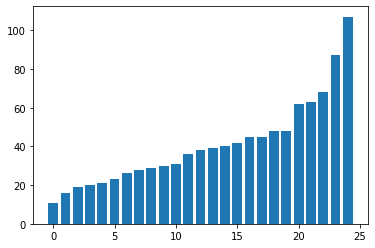

In [2]:
with open("../../../data/2clustering/pairwise_sim.sav", "rb") as f:
    sim, strain2clusters = joblib.load(f)
mapper = umap.UMAP(min_dist=0.0, **GROUPWISE_UMAP_PARAMS).fit(similarity_matrix(sim))
_, _, glabels, _ = cluster_with_hdbscan(mapper.embedding_, GROUPWISE_CLUSTER_RNG, HDBSCAN_PARAMS)

counts = np.unique(glabels, return_counts=True)[1]
plt.bar(range(len(counts)), sorted(counts))
plt.show()

In [ ]:
same_grouping_frac = {strain: np.unique(glabels[idx]).size / len(idx) for strain, idx in strain2clusters.items()}
same_grouping_frac

## Exclude similarity values from same strain

In [3]:
same_strain_map = {}
for strain, idxs in strain2clusters.items():
    for idx in idxs:
        same_strain_map[idx] = [i for i in idxs if i != idx]

retain_idx = []
for i in range(sim.shape[0]):
    if int(sim[i,2]) not in same_strain_map[int(sim[i,1])]:
        retain_idx.append(i)
sim_reduced = sim[retain_idx]

# from sklearn.neighbors import KNeighborsRegressor
# filler = KNeighborsRegressor(n_neighbors=10, weights="distance", metric="canberra", n_jobs=-1)
# for _ in range(10):
#     X_train, X_test, y_train, y_test = train_test_split(sim_reduced[:,1:], sim_reduced[:,0], test_size=0.33, shuffle=True)
#     filler.fit(X_train, y_train)
#     from sklearn.metrics import mean_squared_error
#     print(mean_squared_error(y_test, filler.predict(X_test)))

In [ ]:
same_grouping_frac = {strain: np.unique(glabels[idx]).size / len(idx) for strain, idx in strain2clusters.items()}
same_grouping_frac

# Check similarity between strains

In [7]:
with open("../../../data/2clustering/strainwise_labels.sav", "rb") as f:
    feats, embeddings, labels = joblib.load(f)
clusters, strain2idx = collect_strainwise_clusters(feats, labels, embeddings)
del feats, labels, embeddings
combs = list(combinations(list(strain2idx.keys()), 2))

In [31]:
def cluster_sim(cluster1, cluster2):
    X = [cluster1["feats"], cluster2["feats"]]
    y = [np.zeros((X[0].shape[0],)), np.ones((X[1].shape[0], ))]
    X, y = np.vstack(X), np.hstack(y)

    model = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    model.fit(X, y)
    
    w, mu1, mu2, cov = model.coef_, model.means_[0], model.means_[1], model.covariance_
    w, mu1, mu2 = w.reshape(-1,1), mu1.reshape(-1,1), mu2.reshape(-1,1)
    return (np.dot(w.T, (mu1 - mu2)) ** 2) / np.dot(w.T, np.dot(cov, w))
    

# different strains
bween_strain_sim = []
for strain1, strain2 in random.sample(combs, 10):
    sim = []
    for cluster1 in strain2idx[strain1]:
        for cluster2 in strain2idx[strain2]:
            sim.append(cluster_sim(clusters[cluster1], clusters[cluster2]))
    bween_strain_sim.append(np.array(sim).mean())

# same strain
wthin_strain_sim = []
for strain in random.sample(list(strain2idx.keys()), 10):
    sim = [cluster_sim(clusters[i], clusters[j]) for i, j in combinations(strain2idx[strain], 2)]
    wthin_strain_sim.append(np.array(sim).mean())


-1118.0313655301593 131.5797310123982


In [66]:
np.where(wthin_strain_sim[:,0] < 0.2)[0].size

2647